In [23]:
%matplotlib widget
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
from models import Net_4_layers_v1 as CurrentModel

Import data.

In [2]:
data_a = np.load("../data/dataset_all_H1_bootstrap_O3a.npy")
data_b = np.load("../data/dataset_all_H1_bootstrap_O3b.npy")
data_total = np.vstack([data_a, data_b])

Refering data.

In [3]:
pd.DataFrame(data_total)

,0,1,2,3,4,5,6
0,9.254420,7.831950,385.520985,43.551575,0.170024,-0.226553,3.0
1,4.918122,1.049978,244.809516,79.182049,0.563761,0.184612,0.0
2,5.831387,1.394088,105.503126,11.895160,-0.499879,0.283521,0.0
3,5.171994,1.100152,72.932770,11.926752,0.750677,-0.290788,3.0
4,5.270617,1.455858,73.913381,16.359395,0.543106,-0.148996,0.0
...,...,...,...,...,...,...,...
75595,23.099025,39.565564,91.711134,9.598615,-0.543590,0.430138,4.0
75596,18.977332,26.400047,167.938280,36.568601,-0.208704,0.199369,2.0
75597,45.583568,58.212200,64.404370,34.368289,-0.255531,-0.479915,1.0
75598,4.319583,0.991927,92.770109,17.860022,-0.136445,0.002160,0.0


Divide data into training set, validating set and testing set.

In [4]:
data_length = len(data_total)

training_set_length = int(data_length * 0.7)
validating_set_length = int(data_length * 0.2)
testing_set_length = data_length - training_set_length - validating_set_length

training_set = data_total[0:training_set_length, :]
validating_set = data_total[training_set_length:training_set_length + validating_set_length, :]
testing_set = data_total[training_set_length + validating_set_length:, :]

Determine the device.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Make the data suitable to pytorch.

In [6]:
input_tensor_training = torch.tensor(training_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_training = torch.tensor(training_set[:, 6], dtype=torch.int64).to(device)

input_tensor_validating = torch.tensor(validating_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_validating = torch.tensor(validating_set[:, 6], dtype=torch.int64).to(device)

input_tensor_testing = torch.tensor(testing_set[:, 0:6], dtype=torch.float32).to(device)
label_tensor_testing = torch.tensor(testing_set[:, 6], dtype=torch.int64).to(device)

dataset_training = TensorDataset(input_tensor_training, label_tensor_training)
dataset_validating = TensorDataset(input_tensor_validating, label_tensor_validating)
dataset_testing = TensorDataset(input_tensor_testing, label_tensor_testing)

loader_training = DataLoader(dataset_training, batch_size=32, shuffle=True)
loader_validating = DataLoader(dataset_validating, batch_size=32, shuffle=True)
loader_testing = DataLoader(dataset_testing, batch_size=32, shuffle=True)

Define the model, criterion and optimizer.

In [24]:
model = CurrentModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.002)

In [9]:
loss_average_list = []
accuracy_average_list = []

for epoch in tqdm(range(10), desc="Training ..."):
    correct_predictions = 0
    total_samples = 0
    loss_array = []
    for data in loader_training:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_array.append(loss.item())
        loss_average = sum(loss_array)/len(loss_array)
        
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        pass
    loss_average_list.append(loss_average)
    
    accuracy_average = correct_predictions / total_samples
    accuracy_average_list.append(accuracy_average)


Training ...: 100%|██████████| 10/10 [00:33<00:00,  3.38s/it]


Plot the loss and average.

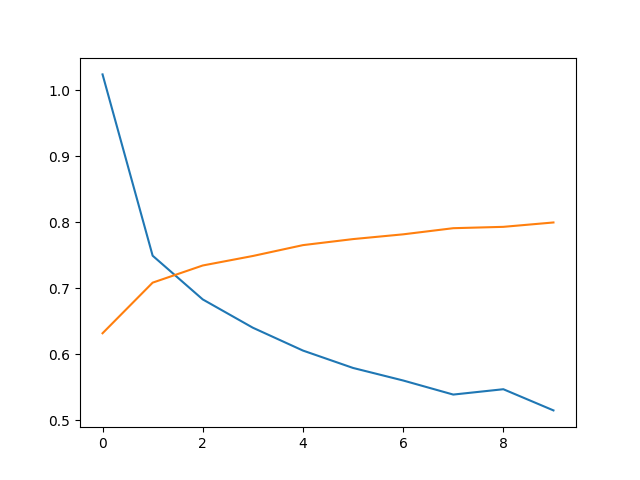

In [11]:
fig, ax = plt.subplots()
ax.plot(loss_average_list)
ax.plot(accuracy_average_list)

Judge the model.

In [12]:
model.eval()
all_predictions = []
all_labels = []

In [13]:
with torch.no_grad():
    for inputs, labels in loader_validating:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Calculate accuracy.

In [14]:
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8167989417989417


In [16]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.77      0.51      0.61      2194
           1       0.88      0.88      0.88      2138
           2       0.93      0.88      0.90      2177
           3       0.63      0.86      0.73      2123
           4       0.87      0.90      0.88      2126
           5       0.87      0.76      0.82      2162
           6       0.82      0.93      0.87      2200

    accuracy                           0.82     15120
   macro avg       0.83      0.82      0.81     15120
weighted avg       0.83      0.82      0.81     15120



In [17]:
print(confusion_matrix(all_labels, all_predictions))

[[1115   23   16  745  108   44  143]
 [  59 1871   26   28   24  122    8]
 [   8   43 1920    5  104   12   85]
 [ 150   15    2 1828    8   63   57]
 [  48    3   31    0 1912    0  132]
 [  62  180    5  245    5 1653   12]
 [   0    0   70   37   42    0 2051]]


Model name.

In [26]:
model_name = "model2312082043remote"

Save the model.

In [21]:
torch.save(model.state_dict(), "../models/" + model_name)

Load the model.

In [27]:
model = CurrentModel().to(device)
model.load_state_dict(torch.load("../models/" + model_name))

<All keys matched successfully>